In [3]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import pathlib
import os

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras import backend as K


In [4]:
# Test if gpu is available
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
tf.test.gpu_device_name()

Num GPUs Available:  0


''

In [3]:
data_dir = pathlib.Path().absolute()
pics = list(data_dir.glob('*/*.jpg'))
pics += list(data_dir.glob('*/*.jpeg'))
pics += list(data_dir.glob('*/*.png'))

print(len(pics))
# PIL.Image.open(pics[2])

1030


In [4]:
data_dir = pathlib.Path().absolute()
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=608)
  # image_size=(img_height, img_width)


Found 1030 files belonging to 6 classes.
Using 824 files for training.


2023-11-30 06:08:16.349541: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-30 06:08:16.349742: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-30 06:08:16.349860: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [5]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=227)


Found 1030 files belonging to 6 classes.
Using 206 files for validation.


In [6]:
class_names = train_ds.class_names
print(class_names)


['.ipynb_checkpoints', 'french_bulldog', 'german_shepherd', 'golden_retriever', 'poodle', 'yorkshire_terrier']


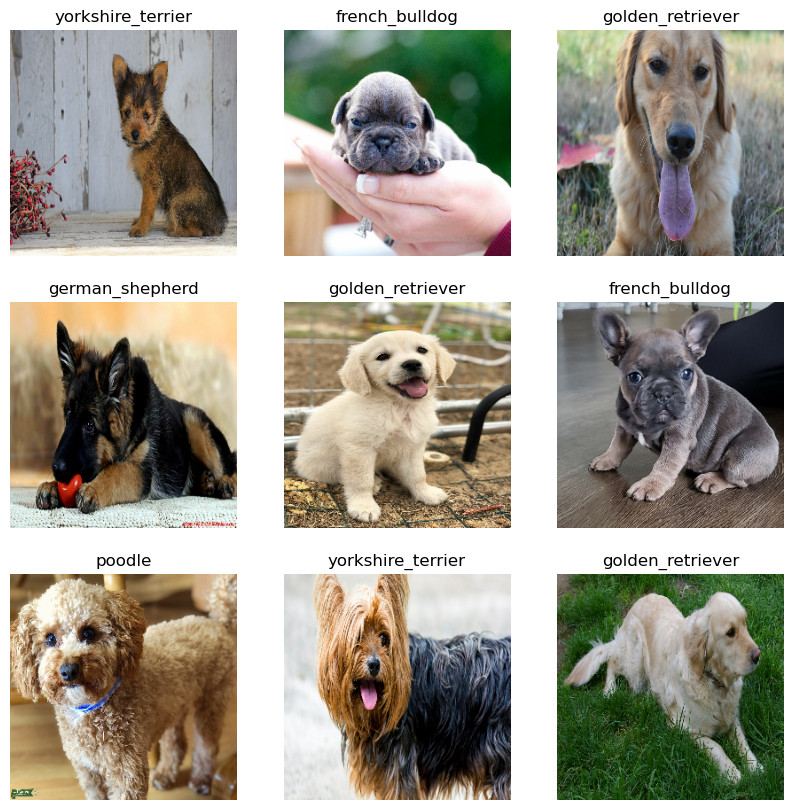

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [8]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 256, 256, 3)
(32,)


In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
num_classes = len(class_names)


In [20]:
# Default Model
K.clear_session()

model = Sequential([
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(64, activation='relu'),
  layers.Dense(num_classes)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [21]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)


Epoch 1/10
26/26 [==============================] - 4s 32ms/step - loss: 1.9355 - accuracy: 0.2597 - val_loss: 1.5618 - val_accuracy: 0.3350
Epoch 2/10
26/26 [==============================] - 1s 30ms/step - loss: 1.4967 - accuracy: 0.3398 - val_loss: 1.4027 - val_accuracy: 0.3641
Epoch 3/10
26/26 [==============================] - 1s 30ms/step - loss: 1.3655 - accuracy: 0.4005 - val_loss: 1.4175 - val_accuracy: 0.3835
Epoch 4/10
26/26 [==============================] - 1s 30ms/step - loss: 1.2586 - accuracy: 0.4891 - val_loss: 1.2031 - val_accuracy: 0.5146
Epoch 5/10
26/26 [==============================] - 1s 29ms/step - loss: 1.0900 - accuracy: 0.5619 - val_loss: 1.0014 - val_accuracy: 0.6117
Epoch 6/10
26/26 [==============================] - 1s 30ms/step - loss: 0.9311 - accuracy: 0.6359 - val_loss: 0.9579 - val_accuracy: 0.6359
Epoch 7/10
26/26 [==============================] - 1s 29ms/step - loss: 0.7725 - accuracy: 0.7160 - val_loss: 0.8325 - val_accuracy: 0.7136
Epoch 8/10
26

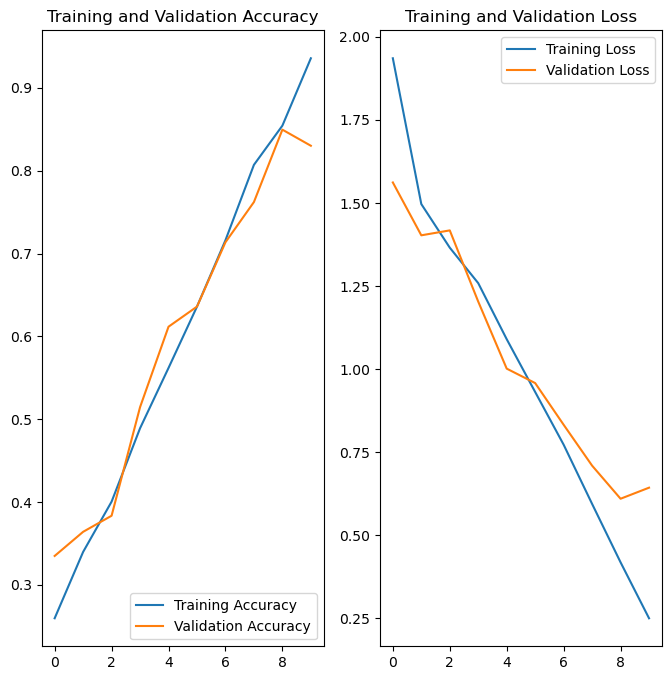

In [22]:
# model.summary()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [23]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.3),
    layers.RandomZoom(0.2),
  ]
)


In [24]:
# Tweaked model
K.clear_session()
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dense(128, activation='relu'),
  layers.Dense(64, activation='relu'),
  layers.Dense(32, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])



model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [25]:
epochs = 100
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)


Epoch 1/100


2023-11-30 06:47:58.907846: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


26/26 [==============================] - 7s 45ms/step - loss: 1.6941 - accuracy: 0.2087 - val_loss: 1.6315 - val_accuracy: 0.1942
Epoch 2/100
26/26 [==============================] - 1s 39ms/step - loss: 1.6253 - accuracy: 0.2306 - val_loss: 1.6120 - val_accuracy: 0.1942
Epoch 3/100
26/26 [==============================] - 1s 42ms/step - loss: 1.6116 - accuracy: 0.2415 - val_loss: 1.6299 - val_accuracy: 0.2330
Epoch 4/100
26/26 [==============================] - 1s 46ms/step - loss: 1.5719 - accuracy: 0.2961 - val_loss: 1.4915 - val_accuracy: 0.3398
Epoch 5/100
26/26 [==============================] - 1s 43ms/step - loss: 1.4799 - accuracy: 0.3265 - val_loss: 1.4875 - val_accuracy: 0.3058
Epoch 6/100
26/26 [==============================] - 1s 38ms/step - loss: 1.4600 - accuracy: 0.3629 - val_loss: 1.4356 - val_accuracy: 0.3592
Epoch 7/100
26/26 [==============================] - 1s 40ms/step - loss: 1.4123 - accuracy: 0.3629 - val_loss: 1.4306 - val_accuracy: 0.3592
Epoch 8/100
26/26 

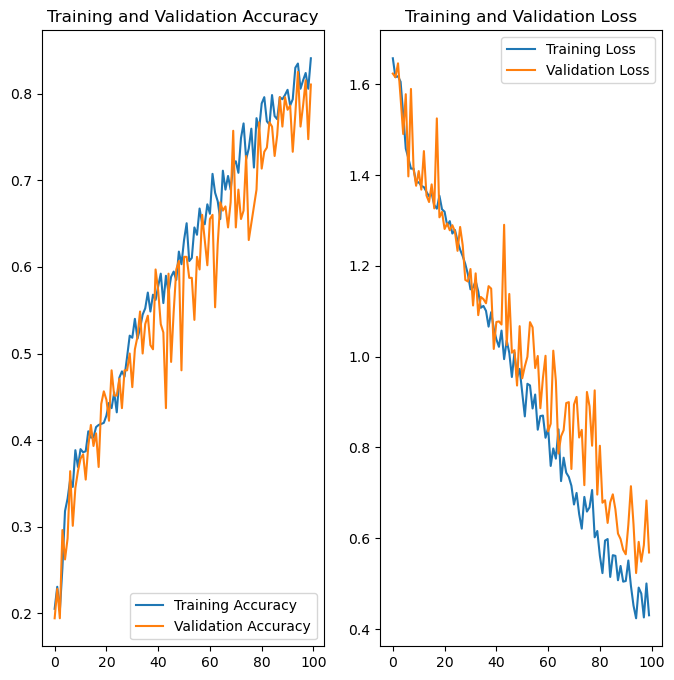

In [16]:
# model.summary()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [17]:
# model.save('./models/2layers_38epochs')